In [62]:
import numpy as np
import torch
import torch.nn as nn

# Word embeddings for the sentence
embeddings = np.array([
    [0.1, 0.2, 0.3, 0.4],  # I
    [0.5, 0.6, 0.7, 0.8],  # like
    [0.9, 0.1, 0.2, 0.3],  # to
    [0.4, 0.5, 0.6, 0.7],  # eat
    [0.8, 0.9, 0.1, 0.2],  # pizza
    [0.3, 0.4, 0.5, 0.6],  # with
    [0.7, 0.8, 0.9, 0.1],  # my
    [0.2, 0.3, 0.4, 0.5]   # friends
])


In [34]:
# Learnable weight matrices for the self-attention mechanism
Wq = np.random.randn(4, 4)
Wk = np.random.randn(4, 4)
Wv = np.random.randn(4, 4)

# Compute query, key, and value matrices
Q = np.dot(embeddings, Wq)
K = np.dot(embeddings, Wk)
V = np.dot(embeddings, Wv)


In [35]:
# Compute raw attention scores
scores = np.dot(Q, K.T) / np.sqrt(K.shape[1])


In [36]:
print('Attention scores:')
print(scores)


Attention scores:
[[-0.39858112 -0.94025587 -0.34638534 -0.80483719 -0.63965399 -0.6694185
  -0.6850346  -0.53399981]
 [-0.83009084 -2.00570912 -0.73586707 -1.71180455 -1.42453128 -1.41789998
  -1.67619379 -1.12399541]
 [-0.36352999 -0.79918234 -0.30195053 -0.69026925 -0.2983715  -0.58135617
  -0.48589061 -0.47244308]
 [-0.72221341 -1.73934581 -0.63849664 -1.48506271 -1.22831196 -1.23077961
  -1.42840399 -0.97649651]
 [-0.19160651 -0.70107629 -0.17659927 -0.57370884 -0.86936073 -0.4463414
  -1.6254242  -0.31897396]
 [-0.61433598 -1.4729825  -0.5411262  -1.25832087 -1.03209264 -1.04365924
  -1.18061419 -0.82899761]
 [-0.28969962 -0.84910548 -0.36425116 -0.70925402 -0.88092343 -0.56940255
  -1.21217159 -0.42955109]
 [-0.50645855 -1.20661919 -0.44375577 -1.03157903 -0.83587332 -0.85653887
  -0.93282439 -0.68149871]]


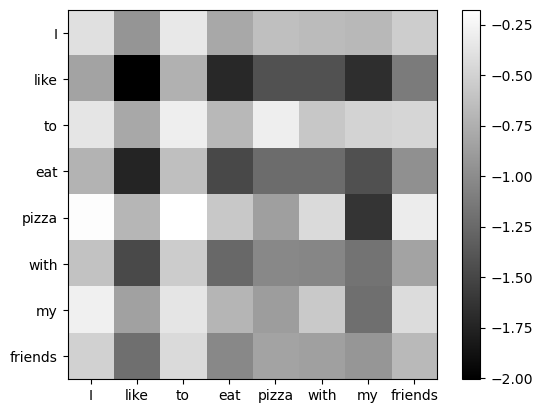

In [37]:
import matplotlib.pyplot as plt

# Plot attention scores as an image
plt.imshow(scores, cmap='gray')
plt.xticks(np.arange(len(embeddings)), ['I', 'like', 'to', 'eat', 'pizza', 'with', 'my', 'friends'])
plt.yticks(np.arange(len(embeddings)), ['I', 'like', 'to', 'eat', 'pizza', 'with', 'my', 'friends'])
plt.colorbar()
plt.show()


In [52]:
import numpy as np

# Load image and divide into patches
image = np.random.randn(224, 224, 3)
patches = np.zeros((14, 14, 768))
for i in range(14):
    for j in range(14):
        patch = image[i*16:(i+1)*16, j*16:(j+1)*16, :]
        patches[i, j, :] = patch.flatten()


In [60]:
patches.shape

(14, 14, 768)

In [66]:
tensor_patches = torch.tensor(patches)

tensor_patches.flatten(1).shape

torch.Size([14, 10752])

In [43]:
# Learnable weight matrices for the self-attention mechanism
Wq = np.random.randn(768, 768)
Wk = np.random.randn(768, 768)
Wv = np.random.randn(768, 768)

# Compute query, key, and value matrices for each patch
Q = np.dot(patches, Wq)
K = np.dot(patches, Wk)
V = np.dot(patches, Wv)

Q.shape

(14, 14, 768)

In [44]:
# Compute raw attention scores
scores = np.dot(Q, K.transpose((0, 2, 1))) / np.sqrt(K.shape[1])

scores.shape

(14, 14, 14, 14)

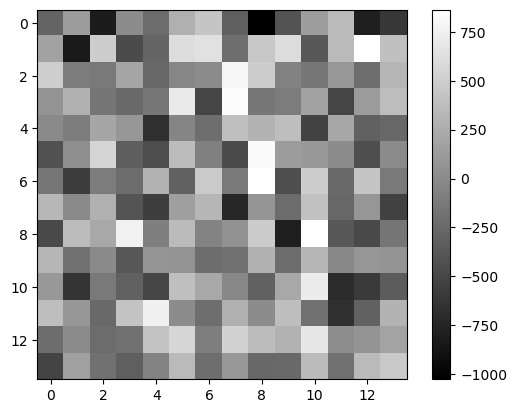

In [45]:
import matplotlib.pyplot as plt

# Plot attention scores as an image
plt.imshow(scores.mean(axis=0).mean(axis=0), cmap='gray')
plt.colorbar()
plt.show()


In [1]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads."

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def _split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        Q = self._split_heads(Q, batch_size)
        K = self._split_heads(K, batch_size)
        V = self._split_heads(V, batch_size)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.head_dim ** 0.5)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-inf"))

        attention = torch.softmax(energy, dim=-1)
        out = torch.matmul(attention, V)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, -1, self.d_model)
        out = self.out_linear(out)

        return out


In [3]:
# Define input
batch_size = 10
seq_length = 8
d_model = 8
num_heads = 2

# Create dummy input tensor with dimensions (batch_size, seq_length, d_model)
input_tensor = torch.randn(batch_size, seq_length, d_model)

# Instantiate the MultiHeadAttention module
mha = MultiHeadAttention(d_model, num_heads)

# Forward pass
output = mha(input_tensor, input_tensor, input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([10, 8, 8])
Output shape: torch.Size([10, 8, 8])


In [38]:
input =torch.tensor(embeddings,dtype=torch.float32).unsqueeze(0)
input.shape

torch.Size([1, 8, 4])

In [39]:
# Define input
d_model = 4
num_heads = 2



# Instantiate the MultiHeadAttention module
mha = MultiHeadAttention(d_model, num_heads)

# Forward pass
output = mha(input, input, input)

print("Input shape:", input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 8, 4])
Output shape: torch.Size([1, 8, 4])


In [40]:
mha 

MultiHeadAttention(
  (q_linear): Linear(in_features=4, out_features=4, bias=True)
  (k_linear): Linear(in_features=4, out_features=4, bias=True)
  (v_linear): Linear(in_features=4, out_features=4, bias=True)
  (out_linear): Linear(in_features=4, out_features=4, bias=True)
)

In [48]:

# Set the 6parameters
d_model =  4  # The dimension of the input (and output) of the transformer layer
nhead = 2         # The number of attention heads in the multi-head self-attention mechanism
dim_feedforward = 1048  # The hidden layer size of the position-wise feed-forward network
dropout = 0.1       # The dropout probability



encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)

# Forward pass
output = encoder_layer(input)

print("Input shape:", input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 8, 4])
Output shape: torch.Size([1, 8, 4])


In [49]:
encoder_layer 

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
  )
  (linear1): Linear(in_features=4, out_features=1048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=1048, out_features=4, bias=True)
  (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [67]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, img_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(img_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_channels, img_size, patch_size, d_model, num_heads, num_layers, num_classes):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbedding(patch_size, img_channels, d_model)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + (img_size // patch_size) ** 2, d_model))

        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model, num_heads) for _ in range(num_layers)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)

        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        for layer in self.layers:
            x = layer(x)

        x = x[:, 0]
        out = self.mlp_head(x)

        return out


In [69]:

img_channels = 3
img_size = 224
patch_size = 16
d_model = 768
num_heads = 12
num_layers = 12
num_classes = 2

# Instantiate the VisionTransformer model
model = VisionTransformer(img_channels, img_size, patch_size, d_model, num_heads, num_layers, num_classes)

# Load an example image
image = Image.open('alien_vs_predator_data/train/alien/0.jpg')
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

# Forward pass
output = model(img_tensor)

print("Input shape:", img_tensor.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 2])
